In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
torch.set_printoptions(precision=6)


In [2]:
raw_data_A = pd.read_csv('data/data_A.csv')
raw_data_B = pd.read_csv('data/data_B.csv')
raw_data_C = pd.read_csv('data/data_C.csv')

In [3]:
data_A = raw_data_A.select_dtypes(include=[np.number])
data_B = raw_data_B.select_dtypes(include=[np.number])
data_C = raw_data_C.select_dtypes(include=[np.number])

In [4]:
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()

In [5]:
split_up_index = int(len(data_A)*0.8)

In [6]:
scaled_train_data_A = scaler_1.fit_transform(data_A[:split_up_index].values)
scaled_train_data_B = scaler_2.fit_transform(data_B[:split_up_index].values)
scaled_train_data_C = scaler_3.fit_transform(data_C[:split_up_index].values)

In [7]:
scaled_test_data_A = scaler_1.transform(data_A[split_up_index:].values)
scaled_test_data_B = scaler_2.transform(data_B[split_up_index:].values)
scaled_test_data_C = scaler_3.transform(data_C[split_up_index:].values)

In [8]:
scaled_train_data_C[13:]

array([[0.        ],
       [0.03059766],
       [0.04546754],
       [0.03116957],
       [0.04175007],
       [0.04832714],
       [0.0303117 ],
       [0.02716614],
       [0.06376894],
       [0.25850729],
       [0.7718044 ],
       [0.01201029],
       [0.01744352],
       [0.06948813],
       [0.05890764],
       [0.04746926],
       [0.05204461],
       [0.0577638 ],
       [0.06434086],
       [0.06577066],
       [0.11752931],
       [0.31484129],
       [0.8204175 ],
       [0.03059766],
       [0.02545039],
       [0.07063197],
       [0.08321418],
       [0.07006005],
       [0.08492994],
       [0.07863883],
       [0.07720904],
       [0.07720904],
       [0.11924507],
       [0.35859308],
       [0.86931656],
       [0.03688876],
       [0.04603946],
       [0.08979125],
       [0.08178439],
       [0.02659422],
       [0.07806691],
       [0.08607378],
       [0.0852159 ],
       [0.08407206],
       [0.14812697],
       [0.4077781 ],
       [1.        ],
       [0.044

In [9]:
def create_sequences_torch(data_A, data_B, data_C, min_length=12):
    output_seq = []
    target = []
    
    for x in range(min_length, len(data_A) - 1):
        inner_seq = torch.tensor(np.column_stack((
            data_A[:x], 
            data_B[:x], 
            data_C[:x]
        )), dtype=torch.float)
        
        output_seq.append(inner_seq)
        target.append(data_C[x + 1])  

    padded_seq = torch.nn.utils.rnn.pad_sequence(output_seq, batch_first=True, padding_value=0)

    return padded_seq, torch.tensor(target, dtype=torch.float32)

In [10]:
train_seq, train_targets = create_sequences_torch(scaled_train_data_A, scaled_train_data_B, scaled_train_data_C)
test_seq, test_targets = create_sequences_torch(scaled_test_data_A, scaled_test_data_B, scaled_test_data_C)

C:\Users\tongc\AppData\Local\Temp\ipykernel_1104\998990354.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return padded_seq, torch.tensor(target, dtype=torch.float32)


In [11]:
print(train_seq.shape)
print(train_targets.shape)

torch.Size([297, 308, 3])
torch.Size([297, 1])


In [12]:
from torch.utils.data import DataLoader, Dataset

def get_lengths(padded_sequences):
        mask = (padded_sequences.abs().sum(dim=2) > 0).int()
        lengths = mask.sum(dim=1)  # Count valid rows
        return lengths


class PreprocessedDataset(Dataset):
    def __init__(self, padded_sequences, labels):
        self.padded_sequences = padded_sequences 
        self.labels = labels  
        self.lengths = get_lengths(padded_sequences)  

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, idx):
        return self.padded_sequences[idx], self.lengths[idx], self.labels[idx]

    
    
# Fix the CustomDataset class
def collate_fn(batch):
    sequences, lengths, labels = zip(*batch) 

    # Convert to tensors
    sequences = torch.stack(sequences)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)

    # Sort sequences by descending length
    lengths, sort_idx = lengths.sort(descending=True)
    sorted_sequences = sequences[sort_idx]
    sorted_labels = labels[sort_idx]

    # Save indices to restore original order after LSTM
    _, original_order = sort_idx.sort()

    return sorted_sequences, lengths, sorted_labels, original_order

# Create datasets and dataloaders
train_set = PreprocessedDataset(train_seq, train_targets)
test_set = PreprocessedDataset(test_seq, test_targets)

train_loader = DataLoader(train_set, 
                        batch_size=64, 
                        shuffle=False,
                        collate_fn=collate_fn) 

test_loader = DataLoader(test_set, 
                       batch_size=64, 
                       shuffle=False,
                       collate_fn=collate_fn) 

In [13]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout,
                        bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 64)
        self.out = nn.Linear(64, 1)
        


    def forward(self, x, lengths, original_order=None):

        lengths = lengths.cpu()
        
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, 
            lengths, 
            batch_first=True, 
            enforce_sorted=True
        )
        
        # Initialize hidden state
        num_directions = 2 if self.lstm.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)
    
        
        # LSTM forward pass
        packed_out, (hn, cn) = self.lstm(packed_input, (h0, c0))
        
        # Unpack the sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        # Apply dropout
        out = self.dropout(out)
        
        # Get the last valid output for each sequence
        last_seq_idxs = lengths - 1
        out = out[torch.arange(out.shape[0]), last_seq_idxs]
        
        # Restore original order if needed
        if original_order is not None:
            out = out[original_order]
        
        
        out = self.fc(out)
        out = self.out(out)
        return out.squeeze()


In [14]:
# Corrected Training Function
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

input_size = 3 
hidden_size = 256
num_layers = 3
dropout = 0.4
learning_rate = 0.001
num_epochs = 50

# Create model
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Modified training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    train_losses = []
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0
        
        # Batch iteration with progress tracking
        for batch_idx, (sorted_sequences, lengths, sorted_labels, original_order) in enumerate(train_loader):
            # Move data to device
            sequences = sorted_sequences.to(device)
            labels = sorted_labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass - unsort output using original_order
            outputs = model(sequences, lengths)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update weights
            optimizer.step()
            
            # Update tracking
            running_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
            
            # Update progress bar

            
        
        # Calculate epoch loss
        epoch_loss = running_loss / total_samples
        train_losses.append(epoch_loss)
        print(f"Epoch: {epoch+1}/{num_epochs},Loss: {epoch_loss}"
            )
    return train_losses


# Corrected Evaluation Function
def evaluate_model(model, test_loader, criterion):
    """Enhanced evaluation function with metrics"""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, seq_lengths, targets, _ in test_loader:  # Unpack all elements
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            outputs = model(sequences, seq_lengths)
            loss = criterion(outputs.squeeze(), targets.float())
            total_loss += loss.item()
            
            # Store predictions and targets
            preds = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()
            
   
            if preds.ndim == 0:  # scalar case
                all_preds.append(preds)
                all_targets.append(targets_np)
            else:
                all_preds.extend(preds.squeeze())
                all_targets.extend(targets_np.squeeze())
    
    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print(f'Test Loss: {avg_loss:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}')
    return np.array(all_preds), np.array(all_targets)

def plot_results(predictions, actuals, title_suffix=''):
    plt.figure(figsize=(15, 6))
    
    # Main plot
    plt.plot(actuals, label='Actual', color='blue', alpha=0.7)
    plt.plot(predictions, label='Predicted', color='red', alpha=0.5, linestyle='--')
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Annotations
    plt.title(f'Predictions vs Actuals {title_suffix}\nMSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Epoch: 1/50,Loss: 0.06478342543095852
Epoch: 2/50,Loss: 0.0467870814305564
Epoch: 3/50,Loss: 0.039857921231324825
Epoch: 4/50,Loss: 0.04368788592191256
Epoch: 5/50,Loss: 0.0422087001930985
Epoch: 6/50,Loss: 0.0406843625410438
Epoch: 7/50,Loss: 0.0407224163061842
Epoch: 8/50,Loss: 0.04191936907493306
Epoch: 9/50,Loss: 0.04020117283469499
Epoch: 10/50,Loss: 0.03955198740367135
Epoch: 11/50,Loss: 0.0397581603089567
Epoch: 12/50,Loss: 0.03933754540126934
Epoch: 13/50,Loss: 0.03836014716939292
Epoch: 14/50,Loss: 0.03789934157848559
Epoch: 15/50,Loss: 0.03493192618844485
Epoch: 16/50,Loss: 0.028878611973439803
Epoch: 17/50,Loss: 0.024345528020802573
Epoch: 18/50,Loss: 0.02487581406378184
Epoch: 19/50,Loss: 0.022433916282423017
Epoch: 20/50,Loss: 0.02617553661668341
Epoch: 21/50,Loss: 0.021589699163656644
Epoch: 22/50,Loss: 0.02147901364247807
Epoch: 23/50,Loss: 0.01914393878620281
Epoch: 24/50,Loss: 0.018844465524434844
Epoch: 25/50,Loss: 0.01793279327289123
Epoch: 26/50,Loss: 0.016432951884

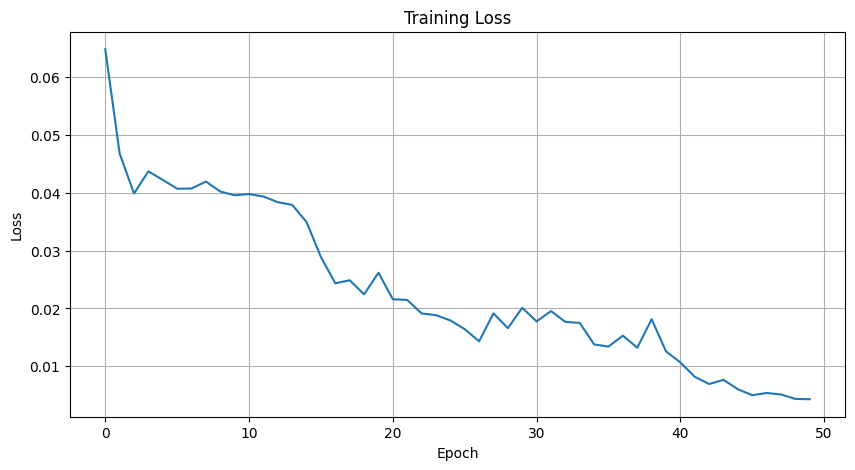

Test Loss: 0.0044 | MSE: 0.0087 | MAE: 0.0707 | R²: 0.5537


C:\Users\tongc\.conda\envs\d2l\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\tongc\AppData\Local\Temp\ipykernel_1104\2471016561.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(all_preds), np.array(all_targets)


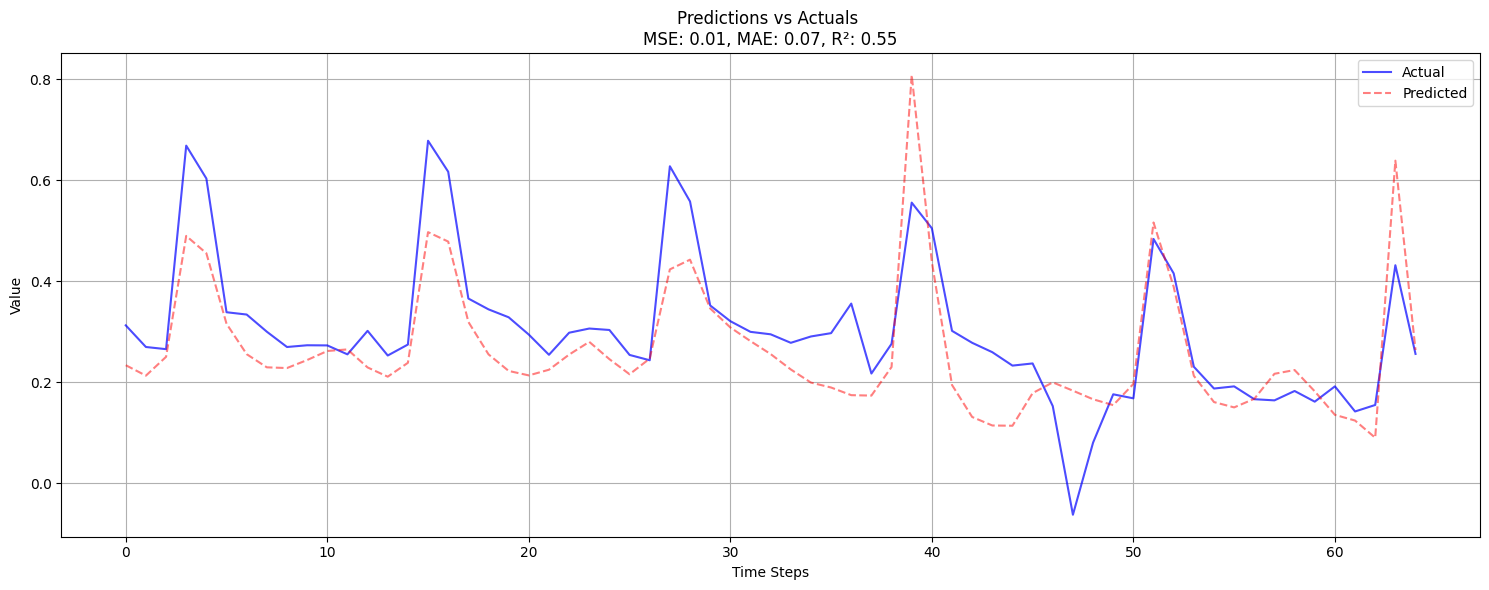

In [15]:

from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader, criterion)

# Plot results
plot_results(predictions, actuals)